In [1]:
import numpy as np
import sympy as sp
from IPython.display import display
sp.init_printing(use_latex=True, latex_mode='plain', scale=1.5, fontsize=10)

In [2]:
w, t, tau_s, tau_m, delay = sp.symbols('w t tau_s tau_m t_delay', real=True, positive=True)

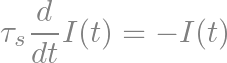

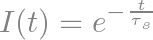

In [3]:
t = sp.symbols('t', real=True)
I = sp.Function('I')(t)
ode_I = sp.Eq(tau_s * sp.Derivative(I, t), -I)
display(ode_I)
soln = sp.dsolve(ode_I, I, ics={I.subs(t, 0): 1})
display(soln)

In [4]:
sp.lambdify(t, soln.rhs.subs({tau_s: 1.0}), 'numpy')(np.arange(0, 30))

array([1.00000000e+00, 3.67879441e-01, 1.35335283e-01, 4.97870684e-02,
       1.83156389e-02, 6.73794700e-03, 2.47875218e-03, 9.11881966e-04,
       3.35462628e-04, 1.23409804e-04, 4.53999298e-05, 1.67017008e-05,
       6.14421235e-06, 2.26032941e-06, 8.31528719e-07, 3.05902321e-07,
       1.12535175e-07, 4.13993772e-08, 1.52299797e-08, 5.60279644e-09,
       2.06115362e-09, 7.58256043e-10, 2.78946809e-10, 1.02618796e-10,
       3.77513454e-11, 1.38879439e-11, 5.10908903e-12, 1.87952882e-12,
       6.91440011e-13, 2.54366565e-13])

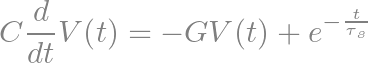

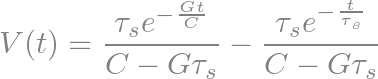

In [5]:
C, G = sp.symbols('C G', real=True, positive=True)
V = sp.Function('V')(t)
ode_V = sp.Eq(C * sp.Derivative(V, t), - G * V + I).subs(I, soln.rhs)
display(ode_V)
soln_V = sp.dsolve(ode_V, V, ics={V.subs(t, 0): 0})
display(soln_V)

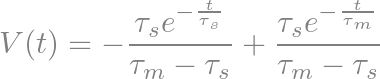

In [6]:
soln_V = soln_V.subs({C:G*tau_m})
soln_V = soln_V.subs({G:1})
soln_V

In [7]:
TAU_D = 10.
TAU_R = 1.

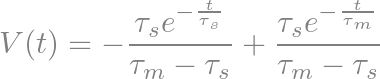

In [8]:
soln_V

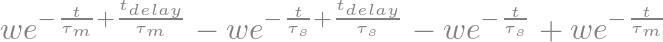

In [9]:
psp = w * (soln_V.rhs + soln_V.rhs.subs({t:(t-delay)}))
# psp.simplify()
psp = psp * (tau_m - tau_s) / tau_s
psp = psp.simplify()
# psp = psp / (sp.exp(-1/tau_m) - sp.exp(-1/tau_s))
psp

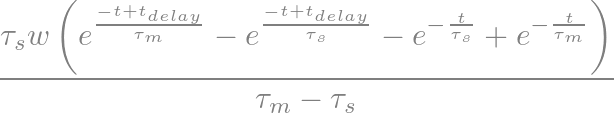

In [10]:
w * tau_s /(tau_m - tau_s) * ((sp.exp(-t/tau_m)-sp.exp(-t/tau_s)) + (sp.exp(-(t-delay)/tau_m)-sp.exp(-(t-delay)/tau_s)))

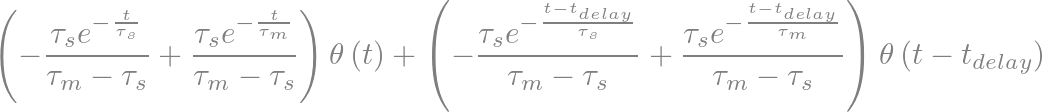

In [11]:
psp_w_heaviside = (soln_V.rhs * sp.Heaviside(t) + soln_V.rhs.subs({t: t - delay}) * sp.Heaviside(t-delay))
psp_w_heaviside

In [12]:
sp.lambdify(t, psp_w_heaviside.subs({tau_s: 1.0, tau_m: 10.0, delay: 0.0, w: .5}), 'numpy')(np.arange(0, 30))

array([0.        , 0.11932399, 0.15186566, 0.15356248, 0.14488987,
       0.13328727, 0.12140731, 0.11014965, 0.09977633, 0.09032139,
       0.0817409 , 0.07396764, 0.06693068, 0.06056212, 0.05479914,
       0.04958441, 0.04486587, 0.04059633, 0.03673308, 0.03323747,
       0.03007451, 0.02721254, 0.02462292, 0.02227974, 0.02015955,
       0.01824111, 0.01650524, 0.01493456, 0.01351335, 0.01222738])

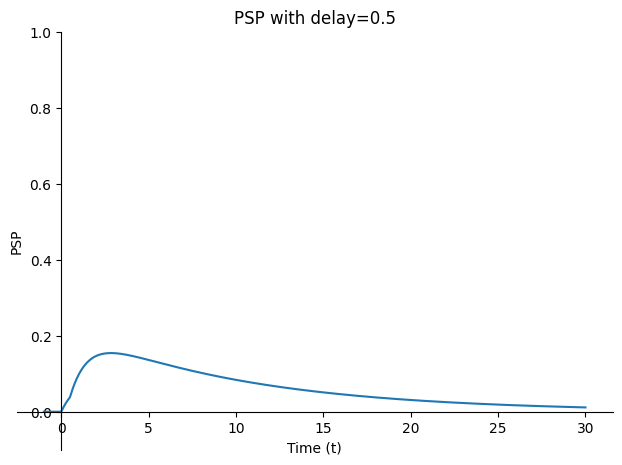

In [13]:
sp.plot(psp_w_heaviside, (t, -1, 30), params={w: 1, tau_s: 1., tau_m: 10., delay: (DELAY:=0.5)}, title=f'PSP with delay={DELAY}', ylabel='PSP', xlabel='Time (t)',
        ylim=(-0.1, 1), axis_center=(0, 0))

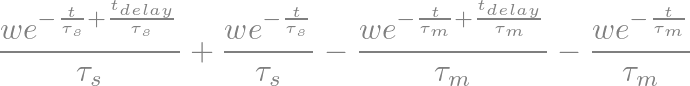

In [14]:
psp_dot = sp.diff(psp, t)
psp_dot

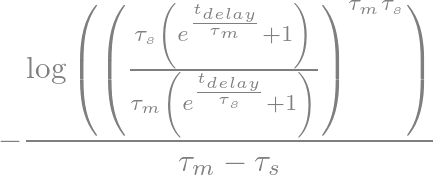

In [15]:
eq_argmax_t = sp.Eq(psp_dot.expand(), 0)
argmax_t = sp.solve(eq_argmax_t, t)[0]
argmax_t

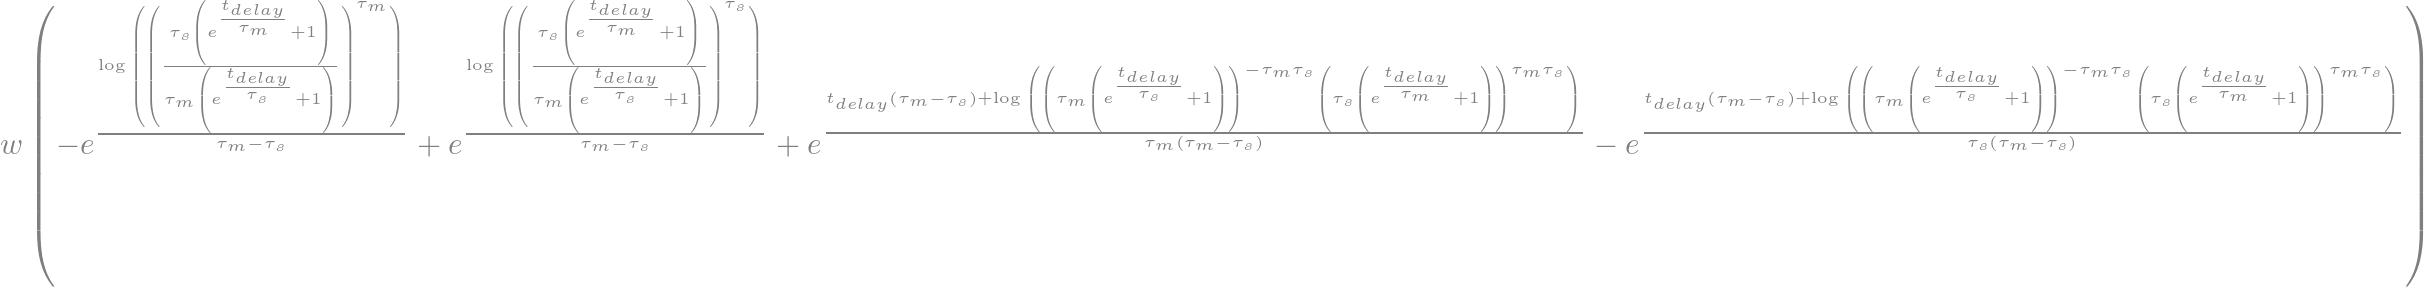

In [16]:
psp_max = sp.simplify(psp.subs(t, argmax_t))
psp_max

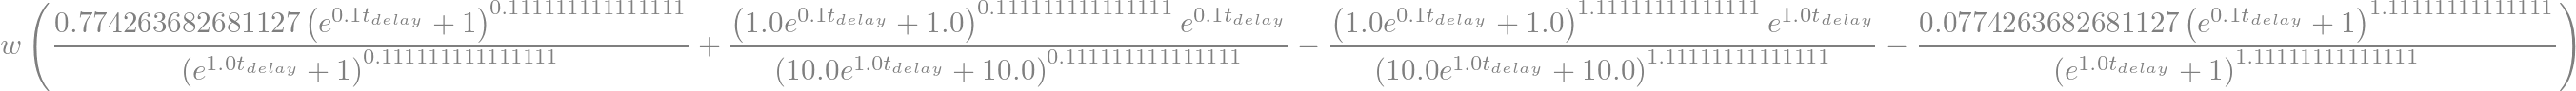

In [17]:
psp_max = psp_max.subs({tau_m: TAU_D, tau_s: TAU_R})
psp_max

In [18]:
w_eq = sp.Eq(psp_max.subs(delay, 1.), 1)
w_eq

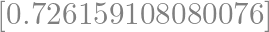

In [19]:
sp.solve(w_eq, w)

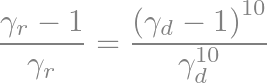

In [96]:
# Gamma is for discrete-time decay, which is tau in SpikingJelly.
# (But note that beta = exp(1/tau): In fact, it is not real time constant, but discrete-time decay factor.)

gamma_r, gamma_d = sp.symbols('gamma_r gamma_d')
eq_beta = sp.Eq((gamma_r - 1)/gamma_r, ((gamma_d - 1)/gamma_d)**10)
eq_beta

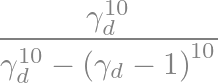

In [97]:
gamma_r_soln = sp.simplify(sp.solve(eq_beta, gamma_r)[0])
gamma_r_soln

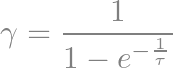

In [98]:
from sympy.abc import tau, gamma

sp.Eq(gamma, 1/(1 - sp.exp(-1/tau)))

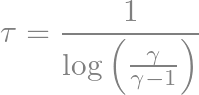

In [99]:
sp.Eq(tau, sp.solve(sp.Eq(gamma, 1/(1 - sp.exp(-1/tau))), tau)[0])

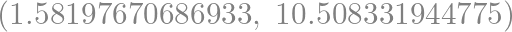

In [100]:
# Convert tau to spkingjelly alpha (beta in our notation)

GAMMA_D = 1/(1 - sp.exp(-1/TAU_D))
GAMMA_R = 1/(1 - sp.exp(-1/TAU_R))
GAMMA_R, GAMMA_D

In [ ]:
gamma_r_soln.evalf(subs={gamma_d: GAMMA_D})

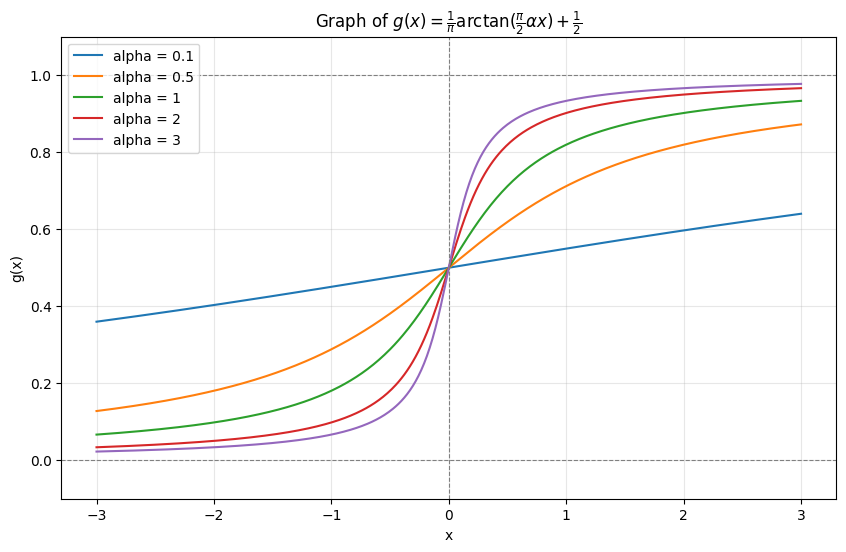

In [26]:
import numpy as np
import matplotlib.pyplot as plt

# 함수 정의
def g(x, alpha):
    return (1 / np.pi) * np.arctan((np.pi / 2) * alpha * x) + 0.5

# x 값 범위 설정 (그래프의 특징을 잘 보여주기 위해 -3에서 3까지 설정)
x = np.linspace(-3, 3, 500)

# alpha 값 리스트
alphas = [0.1, 0.5, 1, 2, 3]

# 그래프 그리기
plt.figure(figsize=(10, 6))

for alpha in alphas:
    plt.plot(x, g(x, alpha), label=f'alpha = {alpha}')

# 그래프 스타일 설정
plt.title(r'Graph of $g(x) = \frac{1}{\pi}\arctan(\frac{\pi}{2}\alpha x) + \frac{1}{2}$')
plt.xlabel('x')
plt.ylabel('g(x)')
plt.axhline(0, color='gray', linewidth=0.8, linestyle='--') # y=0 점근선
plt.axhline(1, color='gray', linewidth=0.8, linestyle='--') # y=1 점근선
plt.axvline(0, color='gray', linewidth=0.8, linestyle='--') # x=0 기준선
plt.legend()
plt.grid(True, alpha=0.3)
plt.ylim(-0.1, 1.1)  # y축 범위 제한

plt.show()

v_analytic: 0.6968361090948764
v_discrete: 2.025431118449939
v_sj: 2.105772018432617


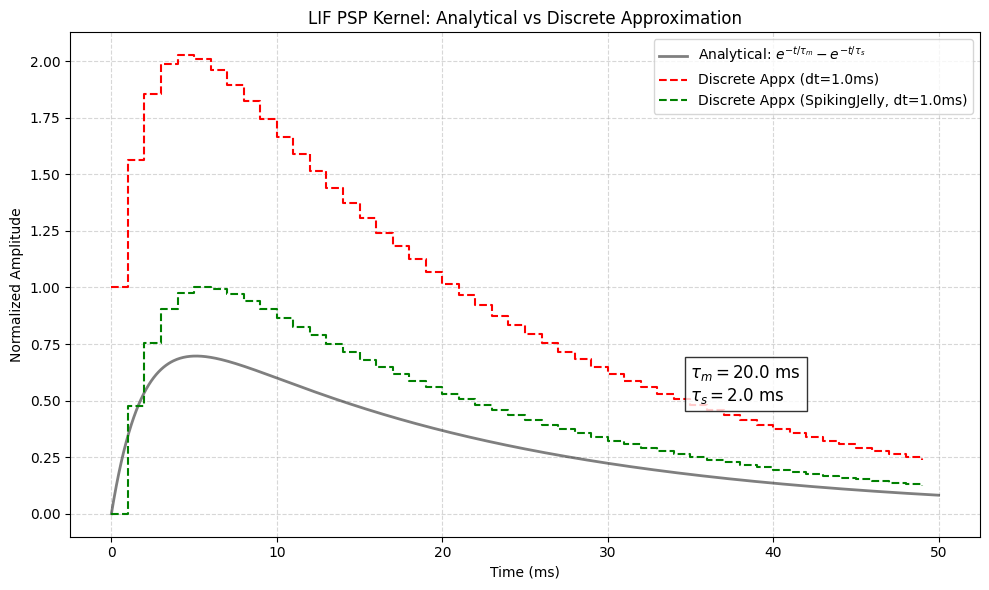

In [79]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from spikingjelly.activation_based.layer import SynapseFilter
from utils.theory import tau2gamma, tau2beta

sfilter = SynapseFilter(tau=tau2gamma(2), step_mode='m')
mfilter = SynapseFilter(tau=tau2gamma(20), step_mode='m')
def plot_lif_psp_comparison():
    # 1. 파라미터 설정
    tau_m = 20.0   # 막 시상수 (Membrane time constant) [ms]
    tau_s = 2.0    # 시냅스 시상수 (Synaptic time constant) [ms]
    dt = 1.0       # 시뮬레이션 시간 간격 (ms). 차이를 잘 보여주기 위해 2ms로 크게 설정
    duration = 50.0 # 전체 시뮬레이션 시간 [ms]
    
    # 시간축 생성
    t_continuous = np.linspace(0, duration, 1000) # 해석적 해를 위한 고해상도 시간축
    t_discrete = np.arange(0, duration, dt)       # 이산 시뮬레이션을 위한 시간축 (dt 간격)
    
    # 2. 해석적 해 (Analytical Solution)
    # 공식: V(t) ∝ exp(-t/tau_m) - exp(-t/tau_s)
    # 두 지수 함수 차이의 형태를 계산하고, 비교를 위해 최댓값을 1로 정규화합니다.
    analytical_curve = np.exp(-t_continuous / tau_m) - np.exp(-t_continuous / tau_s)
    print(f"v_analytic: {analytical_curve.max()}")
    # analytical_curve = analytical_curve / np.max(analytical_curve)
    
    # 3. 이산 시간 근사 (Discrete Time Approximation - SpikingJelly Logic)
    # SpikingJelly에서 SynapseFilter와 LIFNode가 작동하는 방식 시뮬레이션
    # 수식: V[t] = V[t-1] * decay_m + I[t]
    #       I[t] = I[t-1] * decay_s + spike_input
    
    # Decay factor (Exponential Euler 방식)
    decay_m = np.exp(-dt / tau_m)
    decay_s = np.exp(-dt / tau_s)
    
    steps = len(t_discrete)
    v_discrete = np.zeros(steps)
    i_syn = 0.0 # 시냅스 전류 상태
    v_mem = 0.0 # 막전위 상태
    
    # t=0에서 스파이크 입력 발생 가정
    input_spike = 1.0 
    
    for i in range(steps):
        # A. 시냅스 필터 업데이트 (SynapseFilter 역할)
        # 현재 스텝에 들어온 스파이크를 더하고 감쇠
        if i == 0:
            i_syn = i_syn * decay_s + input_spike
        else:
            i_syn = i_syn * decay_s
            
        # B. 막전위 적분 (LIFNode 역할)
        # 이전 전위를 감쇠시키고 현재 전류를 더함
        v_mem = v_mem * decay_m + i_syn
        
        v_discrete[i] = v_mem

    # 이산 값 정규화 (형태 비교를 위해)
    
    correction_coeff = (tau_m - tau_s) / (1/(1-decay_m) - 1/(1-decay_s))
    v_discrete *= correction_coeff
    print(f"v_discrete: {v_discrete.max()}")
    # v_discrete = v_discrete / np.max(v_discrete)
    
    spike_sj = torch.nn.functional.one_hot(torch.tensor(1), num_classes=50).view(-1,1)
    v_sj = mfilter(sfilter(spike_sj))
    print(f"v_sj: {v_sj.max()}")
    v_sj /= torch.max(v_sj)

    # 4. 그래프 그리기
    plt.figure(figsize=(10, 6))
    
    # 해석적 해 그리기 (부드러운 실선)
    plt.plot(t_continuous, analytical_curve, 'k-', linewidth=2, alpha=0.5, label=r'Analytical: $e^{-t/\tau_m} - e^{-t/\tau_s}$')
    
    # 이산 근사 그리기 (Step 형태)
    plt.step(t_discrete, v_discrete, where='post', color='r', linestyle='--', linewidth=1.5, label=f'Discrete Appx (dt={dt}ms)')
    plt.step(t_discrete, v_sj, where='post', color='g', linestyle='--', linewidth=1.5, label=f'Discrete Appx (SpikingJelly, dt={dt}ms)')

    plt.title('LIF PSP Kernel: Analytical vs Discrete Approximation')
    plt.xlabel('Time (ms)')
    plt.ylabel('Normalized Amplitude')
    plt.legend()
    plt.grid(True, which='both', linestyle='--', alpha=0.5)
    
    # 파라미터 정보 표시
    info_text = f'$\\tau_m = {tau_m}$ ms\n$\\tau_s = {tau_s}$ ms'
    plt.text(duration*0.7, 0.5, info_text, fontsize=12, bbox=dict(facecolor='white', alpha=0.8))

    plt.tight_layout()
    plt.show()

# 함수 실행
plot_lif_psp_comparison()

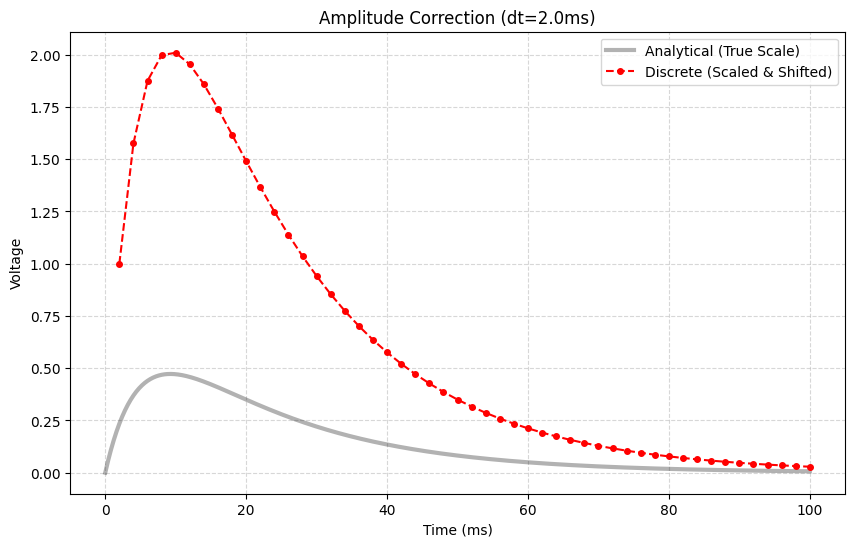

Calculated Scale Factor: 1.0000
Simple dt Scaling (2.0) vs Precise Factor (1.0000) -> Error: 1.0000


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def solve_scale_mismatch():
    # 파라미터
    tau_m = 20.0
    tau_s = 5.0
    dt = 2.0
    duration = 100.0
    
    t_continuous = np.linspace(0, duration, 1000)
    t_discrete = np.arange(0, duration, dt)
    
    # 1. 해석적 해 (Analytical) - 기준(Target)
    # 비교를 위해 이번에는 정규화(Normalize) 하지 않고 '진짜 크기'를 사용합니다.
    # 일반적인 Double Exponential Kernel 식:
    # V(t) = (tau_m / (tau_m - tau_s)) * (exp(-t/tau_m) - exp(-t/tau_s))
    # (단위 크기 1의 전류 펄스가 들어왔을 때의 반응이라고 가정)
    # pre_factor = tau_m / (tau_m - tau_s)
    pre_factor = 1
    y_analytical = pre_factor * (np.exp(-t_continuous/tau_m) - np.exp(-t_continuous/tau_s))

    # 2. 이산 시간 근사 (보정 전)
    decay_m = np.exp(-dt / tau_m)
    decay_s = np.exp(-dt / tau_s)
    
    # 3. 보정 계수 계산 (Correction Factor)
    # 이산 합(Sum)을 연속 적분(Area)과 맞추기 위한 계수
    # 입력 스파이크가 1일 때, 시스템에 전달되는 '전하량'을 맞춰줍니다.
    
    # 방법 A (약식): factor = dt
    # 방법 B (정밀): factor = tau * (1 - decay)
    # 시냅스와 막전위 두 단계를 거치므로 각각에 대해 보정이 필요하거나, 
    # 전체 커널에 대해 넓이 비율을 맞춥니다.
    
    # 가장 확실한 방법: "총 넓이(Area) 비율"로 스케일링
    area_analytical = 1 # (적분 결과)
    sum_discrete = 1/(decay_m - decay_s) # (등비급수 합 결과)
    
    # 스케일 보정 계수
    scale_factor = area_analytical / sum_discrete

    # 시뮬레이션
    v_discrete_fixed = np.zeros(len(t_discrete))
    i_syn = 0.0
    v_mem = 0.0
    
    # 입력에 스케일 팩터 적용!
    input_spike = 1.0 * scale_factor 
    
    for i in range(len(t_discrete)):
        if i == 0: i_syn = i_syn * decay_s + input_spike
        else: i_syn = i_syn * decay_s
        v_mem = v_mem * decay_m + i_syn
        v_discrete_fixed[i] = v_mem

    # 4. 그래프 비교 (Shift 보정도 포함)
    plt.figure(figsize=(10, 6))
    
    plt.plot(t_continuous, y_analytical, 'k-', linewidth=3, alpha=0.3, label='Analytical (True Scale)')
    
    # 시간 지연(Shift)까지 고려하여 그리기 (이전 질문의 통찰 적용)
    plt.plot(t_discrete + dt, v_discrete_fixed, 'r--', marker='o', markersize=4, label='Discrete (Scaled & Shifted)')
    
    plt.title(f'Amplitude Correction (dt={dt}ms)')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.xlabel('Time (ms)')
    plt.ylabel('Voltage')
    
    plt.show()
    print(f"Calculated Scale Factor: {scale_factor:.4f}")
    print(f"Simple dt Scaling ({dt}) vs Precise Factor ({scale_factor:.4f}) -> Error: {abs(dt - scale_factor):.4f}")

solve_scale_mismatch()

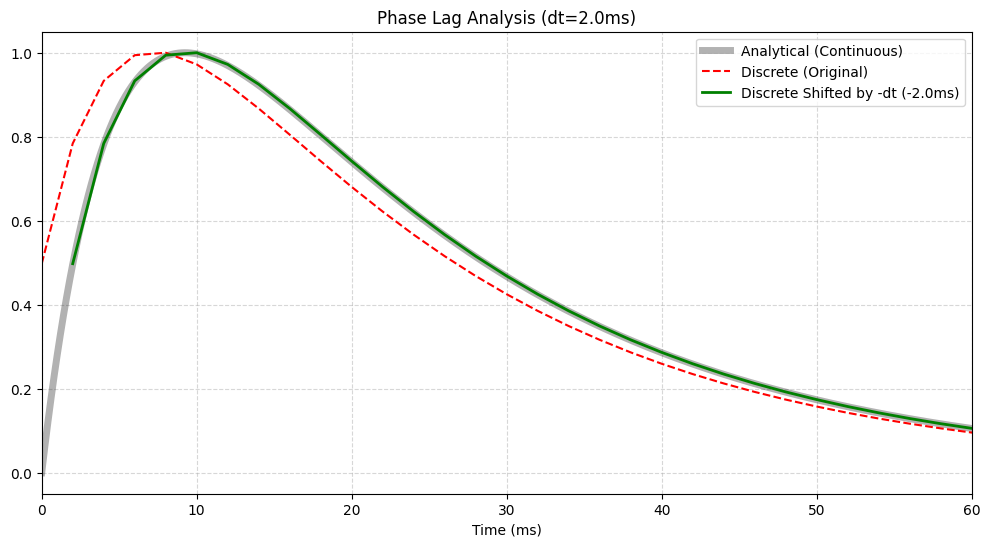

In [28]:
import numpy as np
import matplotlib.pyplot as plt

def plot_lif_psp_shift_check():
    # 파라미터
    tau_m = 20.0
    tau_s = 5.0
    dt = 2.0  # 시간 간격
    duration = 100.0
    
    t_continuous = np.linspace(0, duration, 1000)
    t_discrete = np.arange(0, duration, dt)
    
    # 1. 해석적 해
    analytical_curve = np.exp(-t_continuous / tau_m) - np.exp(-t_continuous / tau_s)
    analytical_curve /= np.max(analytical_curve)
    
    # 2. 이산 시간 근사
    decay_m = np.exp(-dt / tau_m)
    decay_s = np.exp(-dt / tau_s)
    
    v_discrete = np.zeros(len(t_discrete))
    i_syn = 0.0
    v_mem = 0.0
    input_spike = 1.0 
    
    for i in range(len(t_discrete)):
        if i == 0: i_syn = i_syn * decay_s + input_spike
        else: i_syn = i_syn * decay_s
        v_mem = v_mem * decay_m + i_syn
        v_discrete[i] = v_mem

    v_discrete /= np.max(v_discrete)

    # 3. 그래프 그리기
    plt.figure(figsize=(12, 6))
    
    # (A) 원래 해석적 해
    plt.plot(t_continuous, analytical_curve, 'k-', alpha=0.3, linewidth=5, label='Analytical (Continuous)')
    
    # (B) 원래 이산 근사 (빨간 점선)
    plt.plot(t_discrete, v_discrete, 'r--', label='Discrete (Original)')
    
    # (C) 시간을 왼쪽으로 dt만큼 당긴 이산 근사 (초록 실선) - 사용자 가설 검증
    # t_discrete에서 dt만큼 뺍니다.
    plt.plot(t_discrete + dt, v_discrete, 'g-', linewidth=2, label=f'Discrete Shifted by -dt (-{dt}ms)')

    plt.title(f"Phase Lag Analysis (dt={dt}ms)")
    plt.xlabel('Time (ms)')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.xlim(0, 60) # 앞부분 확대
    
    plt.show()

plot_lif_psp_shift_check()

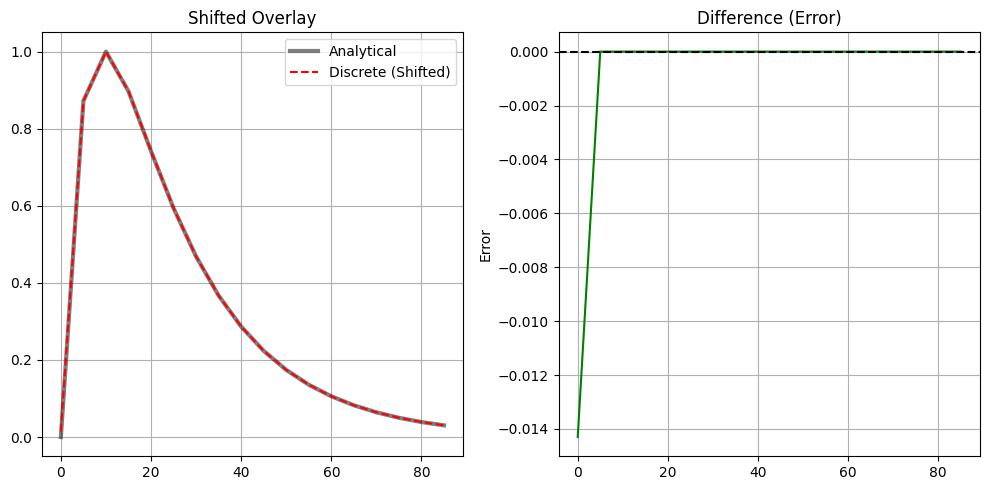

Mean Squared Error: 0.0000113601


In [29]:
import numpy as np
import matplotlib.pyplot as plt

def verify_perfect_match():
    tau_m = 20.0
    tau_s = 5.0
    dt = 5.0 # dt를 일부러 크게 잡아서 형태가 잘 보이게 함
    duration = 100.0
    
    # 시간축 (이산 시간 기준)
    # 해석적 해와 1:1 비교를 위해 같은 시간 포인트만 계산합니다.
    t_points = np.arange(0, duration, dt)
    
    # 1. 해석적 해 (Analytical)
    # t=0일 때 0부터 시작하도록 수식 적용
    y_analytical = np.exp(-t_points / tau_m) - np.exp(-t_points / tau_s)
    y_analytical /= np.max(y_analytical) # 정규화
    
    # 2. 이산 시간 근사 (Discrete)
    decay_m = np.exp(-dt / tau_m)
    decay_s = np.exp(-dt / tau_s)
    
    y_discrete = np.zeros(len(t_points))
    i_syn = 0.0
    v_mem = 0.0
    input_spike = 1.0
    
    for i in range(len(t_points)):
        # 일반적인 구현: Current Update -> Voltage Update
        if i == 0: i_syn = i_syn * decay_s + input_spike
        else: i_syn = i_syn * decay_s
        v_mem = v_mem * decay_m + i_syn
        y_discrete[i] = v_mem

    y_discrete /= np.max(y_discrete) # 정규화
    
    # 3. 위상 보정 (Shift) 및 비교
    # 이산 데이터는 한 스텝 지연되므로, analytical 데이터를 한 칸 뒤로 미루거나
    # discrete 데이터를 한 칸 당겨서 비교해야 합니다.
    # 여기서는 '형태' 비교를 위해 겹치는 구간만 자릅니다.
    
    # Analytical: [0, 1, 2, 3 ...]
    # Discrete:   [0(지연), 1, 2, 3 ...] -> 1스텝 지연 발생
    
    # 비교 구간: Discrete의 [0:-1] 와 Analytical의 [1:] (한 칸 차이 매칭)
    # 주의: 초기값(0) 부분은 과도 응답 때문에 제외하고, 그 이후 감쇠 곡선이 일치하는지 봅니다.
    
    # 쉬운 비교를 위해 discrete를 한 칸(dt) 당겨봅니다 (Shift Left)
    y_discrete_shifted = np.roll(y_discrete, +1)
    
    # 마지막 데이터는 roll로 인해 이상해지므로 제외하고 비교
    limit = -2 
    
    diff = y_analytical[:limit] - y_discrete_shifted[:limit]
    mse = np.mean(diff**2) # 평균 제곱 오차

    # 그래프
    plt.figure(figsize=(10, 5))
    
    plt.subplot(1, 2, 1)
    plt.title("Shifted Overlay")
    plt.plot(t_points[:limit], y_analytical[:limit], 'k-', lw=3, alpha=0.5, label='Analytical')
    plt.plot(t_points[:limit], y_discrete_shifted[:limit], 'r--', label='Discrete (Shifted)')
    plt.legend()
    plt.grid()

    plt.subplot(1, 2, 2)
    plt.title("Difference (Error)")
    plt.plot(t_points[:limit], diff, 'g-')
    plt.axhline(0, color='k', linestyle='--')
    plt.ylabel("Error")
    plt.grid()
    
    plt.tight_layout()
    plt.show()
    
    print(f"Mean Squared Error: {mse:.10f}")

verify_perfect_match()